In [187]:
import pandas as pd
import numpy as np
import scipy as sp
import seaborn as sns
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

# 2-ETL

In [92]:
sc_player_data = pd.read_csv('../data/external/starcraft_player_data.csv')

In [93]:
# removing GameID as it is a column with unique values only
sc_player_data.drop(columns=['GameID'],inplace=True)

### Dealing with '?' values

In [94]:
sc_player_data = sc_player_data.replace('?', np.nan) # temporarily replace '?' with np nan to do further exploration
sc_player_data = sc_player_data.astype({'Age': 'float','HoursPerWeek':'float','TotalHours':'float'}) # since np nan is a float

In [95]:
sc_player_data['Age'] = sc_player_data['Age'].fillna(sc_player_data['Age'].mean())

In [96]:
sc_player_data['HoursPerWeek'] = sc_player_data['HoursPerWeek'].fillna(40) # filling na value with 40 hour work week

In [97]:
# TotalHours
mean_total_hours = sc_player_data.groupby(by=['LeagueIndex'])['TotalHours'].mean().reset_index()
mean_total_hours

,LeagueIndex,TotalHours
0,1,264.191617
1,2,331.409222
2,3,493.792043
3,4,588.006165
4,5,2024.493781
5,6,988.405797
6,7,1581.028571
7,8,NaN


Fitting a curve to interpolate the missing value for Rank 8. 

In [98]:
# Curve Fitting (exponential)
def f(x, m, c):
    return m*x**2+c 
def interpolate(s):
    temp = s.dropna()
    popt, pcov = sp.optimize.curve_fit(f, temp.index, temp)
    output = [i for i in f(s.index, *popt)] 
    return pd.Series(output)

In [99]:
config = {'TotalHours':interpolate}               

interpolated = mean_total_hours.agg(config)
interpolated['LeagueIndex'] = mean_total_hours['LeagueIndex']
interpolated

,TotalHours,LeagueIndex
0,418.636587,1
1,455.349456,2
2,565.488064,3
3,749.052410,4
4,1006.042495,5
5,1336.458319,6
6,1740.299881,7
7,2217.567181,8


In [100]:
sc_player_data['TotalHours'].fillna(interpolated['TotalHours'].iloc[7],inplace=True)

### Removing Outliers 

In [101]:
sc_player_data = sc_player_data[sc_player_data['TotalHours'] != 1000000] # as explained in 1-EDA
sc_player_data = sc_player_data[sc_player_data['HoursPerWeek'] != 168] 

### Removing  correlated features
Removing correlated features helps reduce redundancy and improves the ability to interpret the model.

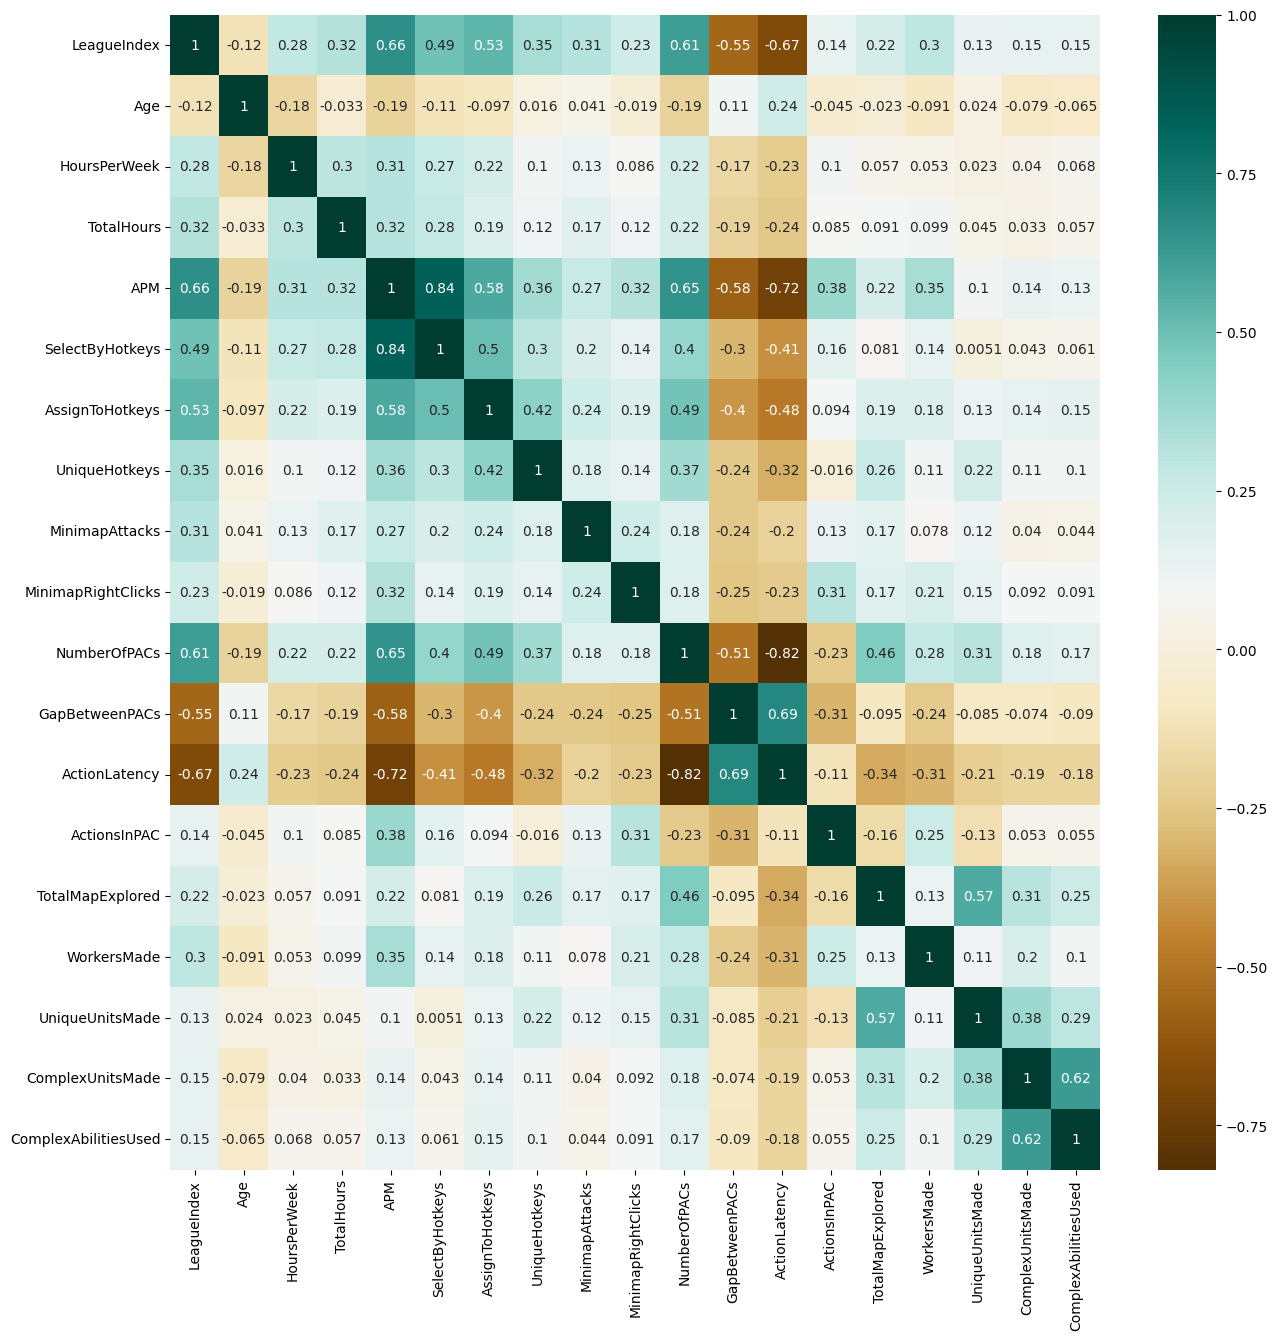

In [108]:
# corr() uses pearson correlation by default
# features = sc_player_data.drop(columns=['LeagueIndex'])
plt.figure(figsize=(15,15))
c = sc_player_data.corr(method='pearson')
corr = sns.heatmap(c,cmap="BrBG",annot=True)

Our function below will help us remove correlated features, but keep the feature that is more correlated to our target variable.

In [180]:
# Helper function that identifies correlated features that are also the least correlated to target variable.
def identify_correlated_features(data, threshold):
    identified_features = set()  
    corr_matrix = data.corr()
    
    # LeagueIndex and Feature correlations
    rank_correlation = {}
    
    for i in range(len(corr_matrix.columns)):    
        for j in range(len(corr_matrix.columns)):
            
            if i == 0: # populate correlations to rank by going through first row only 
                rank_correlation[corr_matrix.columns[j]] = corr_matrix.iloc[i,j]
                           
            else:
                if abs(corr_matrix.iloc[i, j]) > threshold:

                    column_name = corr_matrix.columns[i]  
                    row_name = corr_matrix.columns[j]
                    
                    if column_name != row_name: #
                        if rank_correlation[column_name] > rank_correlation[row_name]:
                            identified_features.add(row_name)
                        else:
                            identified_features.add(column_name)
    return identified_features

In [182]:
identified_correlated_features = identify_correlated_features(sc_player_data,.7)

In [184]:
sc_player_data = sc_player_data.drop(identified_correlated_features,axis=1)

#### Dealing with Class Imbalance with Oversampling (SMOTE) 
Due to the imbalance of classes, our model may over-predict in favor of ranks that are commnonly seen. For example, since rank 4 and 5 are the most common, the model will predict most players to be in rank 4 and 5. 

Oversampling with SMOTE may help address such issues.

In [188]:
sc_player_data['LeagueIndex'].value_counts()

LeagueIndex
4    811
5    805
6    620
3    553
2    347
1    167
8     55
7     35
Name: count, dtype: int64

In [189]:
X = sc_player_data.drop('LeagueIndex',axis=1)  
y = sc_player_data['LeagueIndex'] 

oversample = SMOTE()
X, y = oversample.fit_resample(X, y)

In [191]:
y.value_counts()

LeagueIndex
5    811
4    811
3    811
2    811
1    811
7    811
6    811
8    811
Name: count, dtype: int64

In [193]:
X['LeagueIndex'] = y

In [196]:
sc_player_data = X

In [199]:
sc_player_data.head()

,Age,HoursPerWeek,TotalHours,APM,AssignToHotkeys,UniqueHotkeys,MinimapAttacks,MinimapRightClicks,NumberOfPACs,GapBetweenPACs,ActionsInPAC,TotalMapExplored,WorkersMade,UniqueUnitsMade,ComplexUnitsMade,ComplexAbilitiesUsed,LeagueIndex
0,27.0,10.0,3000.0,143.7180,0.000220,7,0.000110,0.000392,0.004849,32.6677,4.7508,28,0.001397,6,0.0,0.000000,5
1,23.0,10.0,5000.0,129.2322,0.000259,4,0.000294,0.000432,0.004307,32.9194,4.8434,22,0.001193,5,0.0,0.000208,5
2,30.0,10.0,200.0,69.9612,0.000336,4,0.000294,0.000461,0.002926,44.6475,4.0430,22,0.000745,6,0.0,0.000189,4
3,19.0,20.0,400.0,107.6016,0.000213,1,0.000053,0.000543,0.003783,29.2203,4.9155,19,0.000426,7,0.0,0.000384,3
4,32.0,10.0,500.0,122.8908,0.000327,2,0.000000,0.001329,0.002368,22.6885,9.3740,15,0.001174,4,0.0,0.000019,3
